In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV

In [2]:
# Have some time series data (via pandas)
df = pd.read_csv('dataset02.csv')


In [3]:
df.head()

,aMean_0,std_0,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,...,covar_01,covar_02,covar_03,covar_12,covar_13,covar_23,y0,y1,y2,y3
0,0.058332,0.073477,0.096,0.083993,0.628763,985.351562,52.733122,0.074179,6593.0,0.840,...,0.001398,-0.000501,-0.000304,-0.000295,-0.000837,0.000214,0.0,0.0,0.0,0.0
1,0.058997,0.075340,0.097,0.052142,0.648291,985.351562,51.201049,0.075382,6867.0,0.757,...,0.001287,-0.000289,-0.000188,-0.000216,-0.000852,0.000322,0.0,0.0,0.0,0.0
2,0.060239,0.076191,0.100,0.032808,0.513475,985.351562,50.779361,0.076230,6637.0,0.903,...,0.001349,-0.000503,-0.000284,-0.000487,-0.001030,0.000356,0.0,0.0,0.0,0.0
3,0.061453,0.078693,0.100,0.041486,1.157953,985.351562,51.079815,0.078724,6659.0,1.184,...,0.001410,-0.000455,-0.000221,-0.000525,-0.000961,0.000272,0.0,0.0,0.0,0.0
4,0.061361,0.078439,0.103,0.028224,0.603177,985.351562,50.279226,0.078474,6765.0,0.782,...,0.001668,-0.000510,-0.000310,-0.000548,-0.001050,0.000355,0.0,0.0,0.0,0.0


In [4]:
idx=0
for i in range(len(df)):
    idx+=1
    if idx>(len(df)-288):
        df.iloc[i]['y0']=1


In [5]:
df['y0'].value_counts()

0.0    696
1.0    288
Name: y0, dtype: int64

In [6]:
df.columns.values

array(['aMean_0', 'std_0', 'irq_0', 'skew_0', 'kurtosis_0', 'f0_0',
       'Pf0_0', 'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0',
       'shape_0', 'impulse_0', 'aMean_1', 'std_1', 'irq_1', 'skew_1',
       'kurtosis_1', 'f0_1', 'Pf0_1', 'Xrms_1', 'zeroX_1', 'p2p_1',
       'crest_1', 'clearance_1', 'shape_1', 'impulse_1', 'aMean_2',
       'std_2', 'irq_2', 'skew_2', 'kurtosis_2', 'f0_2', 'Pf0_2',
       'Xrms_2', 'zeroX_2', 'p2p_2', 'crest_2', 'clearance_2', 'shape_2',
       'impulse_2', 'aMean_3', 'std_3', 'irq_3', 'skew_3', 'kurtosis_3',
       'f0_3', 'Pf0_3', 'Xrms_3', 'zeroX_3', 'p2p_3', 'crest_3',
       'clearance_3', 'shape_3', 'impulse_3', 'covar_01', 'covar_02',
       'covar_03', 'covar_12', 'covar_13', 'covar_23', 'y0', 'y1', 'y2',
       'y3'], dtype=object)

creamos un nuevo dataframe para hacer predicciones sobre el rodamiento del cual tenemos la informacion que fue el primero en fallar.

In [31]:
new_features=['irq_0', 'skew_0', 'kurtosis_0', 'f0_0',
       'Pf0_0', 'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0','shape_0'] #media,desvio e impulso no lo incluimos por lo de la otra note


In [32]:
df0=df[new_features]

irq_0
skew_0
kurtosis_0
f0_0
Pf0_0
Xrms_0
zeroX_0
p2p_0
crest_0
clearance_0
shape_0


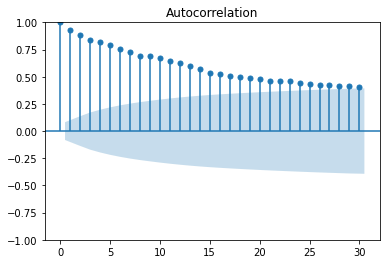

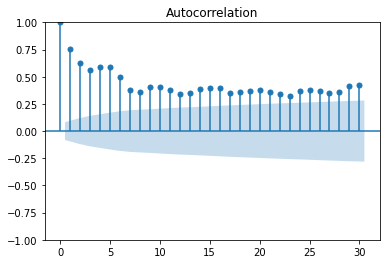

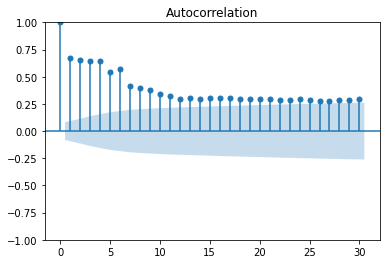

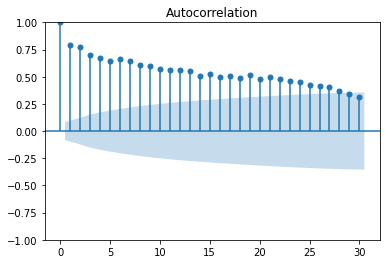

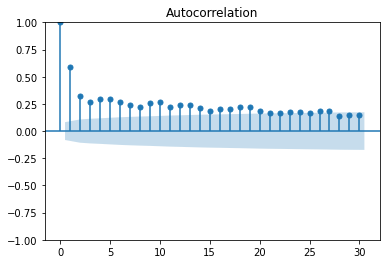

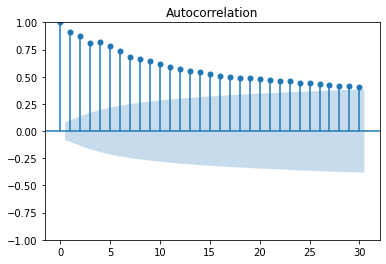

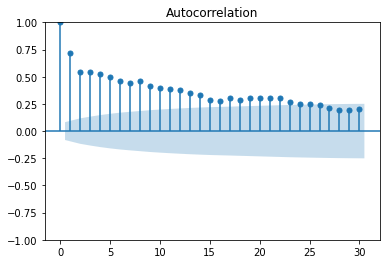

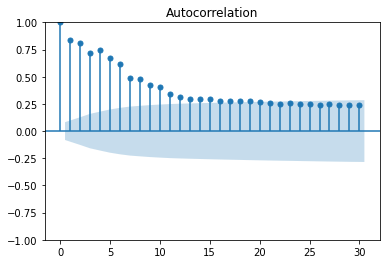

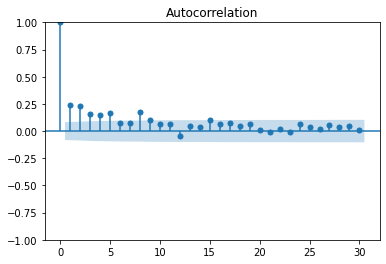

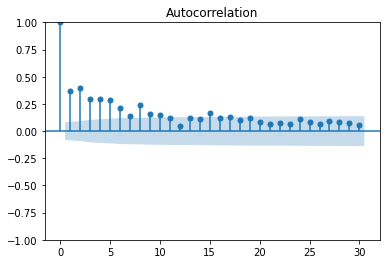

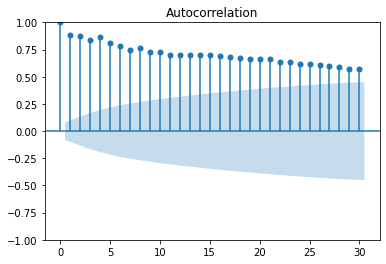

In [35]:
for i in df0.columns:
    #acf_plot=plot_acf(df2[i])
    print(i)
    plot_acf(df0[i],alpha=0.01)

In [36]:
features=['irq_0', 'skew_0', 'kurtosis_0', 'f0_0',
       'Pf0_0', 'Xrms_0', 'zeroX_0', 'p2p_0', 'crest_0', 'clearance_0','shape_0','y0']

In [37]:
df_new=df[features]

In [38]:
df_new.head()

,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,crest_0,clearance_0,shape_0,y0
0,0.096,0.083993,0.628763,985.351562,52.733122,0.074179,6593.0,0.840,6.120331,9.258404,1.271660,0.0
1,0.097,0.052142,0.648291,985.351562,51.201049,0.075382,6867.0,0.757,4.895038,7.450864,1.277742,0.0
2,0.100,0.032808,0.513475,985.351562,50.779361,0.076230,6637.0,0.903,6.598472,9.907938,1.265456,0.0
3,0.100,0.041486,1.157953,985.351562,51.079815,0.078724,6659.0,1.184,7.723217,11.794197,1.281033,0.0
4,0.103,0.028224,0.603177,985.351562,50.279226,0.078474,6765.0,0.782,4.982524,7.622802,1.278896,0.0


In [41]:
df0.head()

,irq_0,skew_0,kurtosis_0,f0_0,Pf0_0,Xrms_0,zeroX_0,p2p_0,crest_0,clearance_0,shape_0
0,0.096,0.083993,0.628763,985.351562,52.733122,0.074179,6593.0,0.840,6.120331,9.258404,1.271660
1,0.097,0.052142,0.648291,985.351562,51.201049,0.075382,6867.0,0.757,4.895038,7.450864,1.277742
2,0.100,0.032808,0.513475,985.351562,50.779361,0.076230,6637.0,0.903,6.598472,9.907938,1.265456
3,0.100,0.041486,1.157953,985.351562,51.079815,0.078724,6659.0,1.184,7.723217,11.794197,1.281033
4,0.103,0.028224,0.603177,985.351562,50.279226,0.078474,6765.0,0.782,4.982524,7.622802,1.278896


Transformacion del dataset

In [40]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 


In [42]:

df_tr = series_to_supervised(df0, 5)


In [45]:
df0.shape

(984, 11)

In [43]:
df_tr.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
5,0.096,0.083993,0.628763,985.351562,52.733122,0.074179,6593.0,0.840,6.120331,9.258404,...,0.026853,0.456094,986.328125,49.566302,0.078315,6729.0,0.805,5.605593,8.467789,1.269929
6,0.097,0.052142,0.648291,985.351562,51.201049,0.075382,6867.0,0.757,4.895038,7.450864,...,0.058595,0.478615,985.351562,52.829410,0.078632,6566.0,0.796,4.934350,7.455333,1.269413
7,0.100,0.032808,0.513475,985.351562,50.779361,0.076230,6637.0,0.903,6.598472,9.907938,...,0.082582,0.471982,985.351562,51.773658,0.077773,6602.0,0.749,5.336050,8.061922,1.270148
8,0.100,0.041486,1.157953,985.351562,51.079815,0.078724,6659.0,1.184,7.723217,11.794197,...,-0.008060,0.404514,986.328125,51.458994,0.079029,6643.0,0.747,4.884256,7.375026,1.268910
9,0.103,0.028224,0.603177,985.351562,50.279226,0.078474,6765.0,0.782,4.982524,7.622802,...,0.046321,0.325203,986.328125,49.821537,0.075718,6508.0,0.722,4.992237,7.486311,1.264218


In [46]:
target=df['y0']
df_tr['y0']=target
df_tr.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),y0
5,0.096,0.083993,0.628763,985.351562,52.733122,0.074179,6593.0,0.840,6.120331,9.258404,...,0.456094,986.328125,49.566302,0.078315,6729.0,0.805,5.605593,8.467789,1.269929,0.0
6,0.097,0.052142,0.648291,985.351562,51.201049,0.075382,6867.0,0.757,4.895038,7.450864,...,0.478615,985.351562,52.829410,0.078632,6566.0,0.796,4.934350,7.455333,1.269413,0.0
7,0.100,0.032808,0.513475,985.351562,50.779361,0.076230,6637.0,0.903,6.598472,9.907938,...,0.471982,985.351562,51.773658,0.077773,6602.0,0.749,5.336050,8.061922,1.270148,0.0
8,0.100,0.041486,1.157953,985.351562,51.079815,0.078724,6659.0,1.184,7.723217,11.794197,...,0.404514,986.328125,51.458994,0.079029,6643.0,0.747,4.884256,7.375026,1.268910,0.0
9,0.103,0.028224,0.603177,985.351562,50.279226,0.078474,6765.0,0.782,4.982524,7.622802,...,0.325203,986.328125,49.821537,0.075718,6508.0,0.722,4.992237,7.486311,1.264218,0.0


In [47]:
df_tr.columns.values

array(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'y0'],
      dtype=object)

In [48]:
features=['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)']
ytarget='y0'

In [49]:
x_=df_tr[features]
y_=df_tr[ytarget]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=10)

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_array = sc.fit_transform(X_train.values)
X_train = pd.DataFrame(X_train_array, index=X_train.index, columns=X_train.columns)
X_test_array = sc.transform(X_test.values)
X_test = pd.DataFrame(X_test_array, index=X_test.index, columns=X_test.columns)

In [52]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(criterion='gini',min_samples_split=20,random_state=99)
tree.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_split=20, random_state=99)

In [54]:
predictions=tree.predict(X_test)
predictions

array([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0.])

In [55]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.9744897959183674

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predictions,labels=[0,1])

array([[138,   4],
       [  1,  53]], dtype=int64)

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest=RandomForestClassifier(n_jobs=2,oob_score=True,n_estimators=500)
forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=500, n_jobs=2, oob_score=True)

In [59]:
forest.oob_score_ 

0.9974457215836526

Pycaret

In [60]:
from pycaret.classification import *

In [65]:
exp=setup(df_tr,target='y0',fold_shuffle=True)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:57:18
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
var1(t-5),Numeric
var2(t-5),Numeric
var3(t-5),Numeric
var4(t-5),Numeric
var5(t-5),Numeric
...,...
var8(t),Numeric
var9(t),Numeric
var10(t),Numeric
var11(t),Numeric
